In [80]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [81]:
df = pd.read_csv("data/smartnas_customer_reviews.csv")
df.head()

,review_id,username,content,rating,review_date
0,0ca3b1b1-8512-4333-8da7-78ba86888b86,Phal Dara,👍👍,4,2025-07-25 12:45:15
1,99d1d5ff-6297-4a84-a79e-9ffdecb21959,Phanna A,poor internet 🤡,1,2025-07-24 07:11:41
2,ba1b5ceb-e7e2-4f12-b4f6-deae12129498,Razy U,ដូចអាចម៍,1,2025-07-24 00:01:59
3,765f97ba-945b-43ee-ac23-0341fe8712c1,Sopheak Sok,ដូចអាចម៍,5,2025-07-23 07:57:03
4,71eec25e-cd5a-46ab-9a4b-107bb57bfc26,RW Media,"very slow, take long time to start the app",2,2025-07-23 07:17:02


In [82]:
print(df.isnull().sum())

review_id      0
username       0
content        0
rating         0
review_date    0
dtype: int64


In [83]:
import emoji
import regex

def clean_text(text):
    if not isinstance(text, str):
        return ''
    no_emoji = emoji.replace_emoji(text, replace='')
    no_khmer = regex.sub(r'\p{IsKhmer}+', '', no_emoji)
    return no_khmer.strip()

df['content'] = df['content'].apply(clean_text)
df = df[df['content'].str.strip() != ''].reset_index(drop=True)

In [84]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

def remove_stopwords(text):
    return " ".join([word for word in text.split() if word.lower() not in ENGLISH_STOP_WORDS])

df['content'] = df['content'].apply(remove_stopwords)

In [85]:
from textblob import TextBlob

def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

df['sentiment_score'] = df['content'].apply(get_sentiment)

def label_sentiment(score):
    if score > 0.05:
        return 'Positive'
    elif score < -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment'] = df['sentiment_score'].apply(label_sentiment)

In [86]:
df[['content', 'sentiment_score', 'sentiment']].head()

,content,sentiment_score,sentiment
0,poor internet,-0.40000,Negative
1,"slow, long time start app",-0.17500,Negative
2,good,0.70000,Positive
3,can't launch,0.00000,Neutral
4,Smart Company crazy? slow card? money runs qui...,-0.20873,Negative


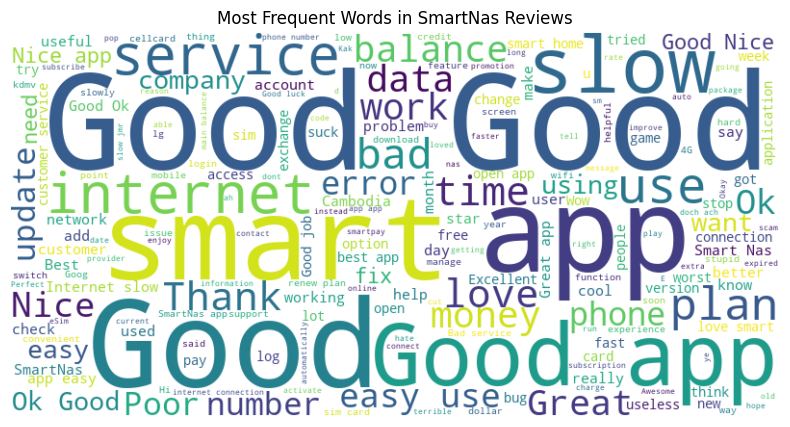

In [88]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all cleaned review texts
all_text = " ".join(df['content'])

# Generate and display the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Frequent Words in SmartNas Reviews")
plt.show()

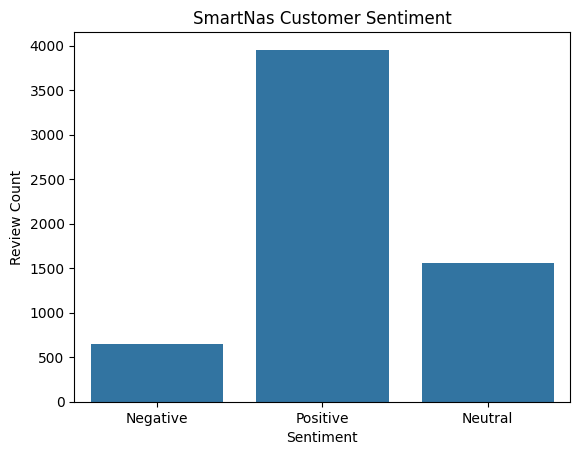

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x='sentiment')
plt.title("SmartNas Customer Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Review Count")
plt.show()

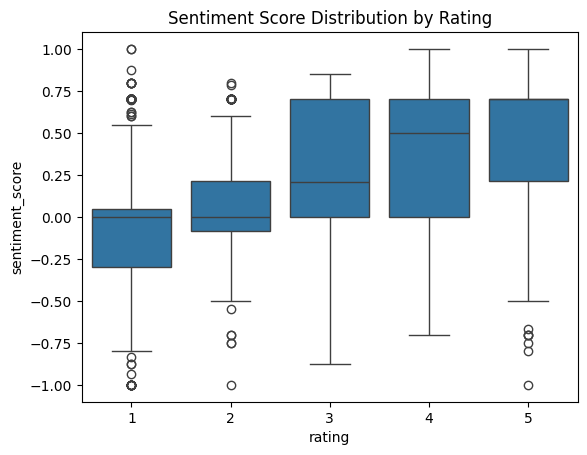

In [90]:
# Sentiment Breakdown by Rating
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=df, x='rating', y='sentiment_score')
plt.title("Sentiment Score Distribution by Rating")
plt.show()

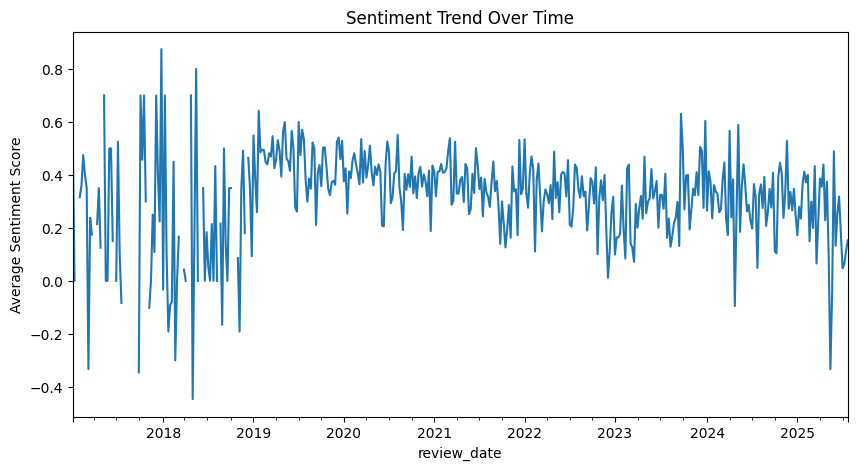

In [91]:
# Sentiment Over Time
# Show if things are getting better or worse

df['review_date'] = pd.to_datetime(df['review_date'])
df.set_index('review_date', inplace=True)
df.resample('W')['sentiment_score'].mean().plot(title="Sentiment Trend Over Time", figsize=(10, 5))
plt.ylabel("Average Sentiment Score")
plt.show()

<Axes: xlabel='sentiment', ylabel='rating'>

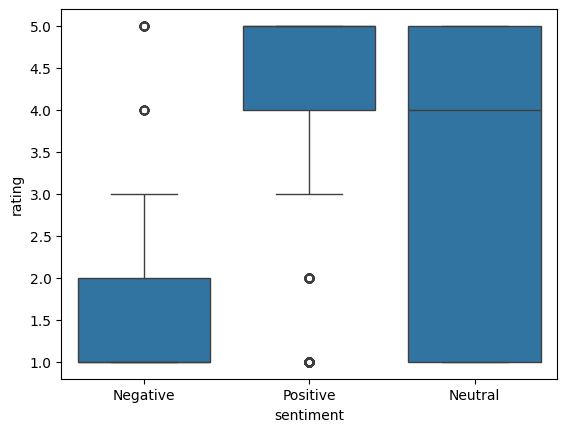

In [96]:
# Check correlation between star ratings and sentiment scores
sns.boxplot(x='sentiment', y='rating', data=df)